# Continuous Vaccination Time-Series Plots - $f_V < f_V^*$ 

## Commands added to run from Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/VaccineFailure/VaccineEfficacy/WORKING

Mounted at /content/gdrive
/content/gdrive/My Drive/VaccineFailure/VaccineEfficacy/WORKING


In [2]:
pip install blackcellmagic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 156 kB 7.4 MB/s 
     |████████████████████████████████| 843 kB 42.8 MB/s 
     |████████████████████████████████| 121 kB 38.3 MB/s 
     |████████████████████████████████| 1.6 MB 38.1 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1


In [4]:
import sys
sys.path.insert(0,'/content/gdrive/My Drive/VaccineFailure/VaccineEfficacy')

## Code that runs locally or via Colab

In [3]:
%load_ext blackcellmagic

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
from utils import seir_ivp, run_modified_seir_ivp
from plot import plot_timeseries

In [6]:
def modified_seir_ivp_cont(t, y, beta, sigma, gamma, v, fv, epsL, epsA):
    """
    Modified SEIR model for continuous vaccination. 
    """
    s, vs, vr, e, i, r = y
    
    dsdt = - beta*s*i - v*(1-(vs+vr)/fv)*s
    dvsdt = (1 - epsA)*v*(1-(vs+vr)/fv)*s - beta*vs*i
    dvrdt = epsA*v*(1-(vs+vr)/fv)*s - beta*(1-epsL)*vr*i
    dedt = beta*(s+vs+(1-epsL)*vr)*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i

    return [dsdt, dvsdt, dvrdt, dedt, didt, drdt]

In [7]:
def run_modified_seir_ivp_cont(
    y0: list,
    t: float,
    tv: float,
    beta: float,
    sigma: float,
    gamma: float,
    fv: float,
    eps: float,
    v: float,
    mode: str = "leaky",
):
    s0, e0, i0, r0 = y0
    if mode == "leaky":
        epsL = eps
        epsA = 1
    elif mode == "aon":
        epsL = 1
        epsA = eps
    else:
        print("Mode must be 'leaky' or 'aon'.")

    if tv == -1:
        vs0 = 0
        vr0 = 0
        y0_vax = [s0, vs0, vr0, e0, i0, r0]
        sol_vax = solve_ivp(
            modified_seir_ivp_cont,
            [0, t],
            y0_vax,
            args=(beta, sigma, gamma, v, fv, epsL, epsA),
            dense_output=True,
            t_eval=np.linspace(0, t, t+1)
        )
        s_vax = sol_vax.y[0]
        vs = sol_vax.y[1]
        vr = sol_vax.y[2]
        e_vax = sol_vax.y[3]
        i_vax = sol_vax.y[4]
        r_vax = sol_vax.y[5]
        v = vs + vr

        return s_vax, vs, vr, v, e_vax, i_vax, r_vax

    else:
        if math.floor(tv) == tv:
            t_eval1 = np.linspace(0, tv, tv+1)
            t_eval2 = np.linspace(tv, t, t-tv+1)
        else:
            t_eval1 = np.append(np.linspace(0, math.floor(tv), math.floor(tv)+1), [tv])
            t_eval2 = np.linspace(math.floor(tv)+1, t, t-math.floor(t)+1)
        sol = solve_ivp(
            seir_ivp,
            [0, tv],
            y0,
            args=(beta, sigma, gamma),
            dense_output=True,
            t_eval = t_eval1
        )
        s = sol.y[0]
        e = sol.y[1]
        i = sol.y[2]
        r = sol.y[3]

        vs0 = 0
        vr0 = 0
        y0_vax = [s[-1], vs0, vr0, e[-1], i[-1], r[-1]]
        sol_vax = solve_ivp(
            modified_seir_ivp_cont,
            [tv, t],
            y0_vax,
            args=(beta, sigma, gamma, v, fv, epsL, epsA),
            dense_output=True,
            t_eval = t_eval2
        )
        s_vax = sol_vax.y[0]
        vs = sol_vax.y[1]
        vr = sol_vax.y[2]
        e_vax = sol_vax.y[3]
        i_vax = sol_vax.y[4]
        r_vax = sol_vax.y[5]
        v = vs + vr

        s_vax = np.concatenate((s[:-1], s_vax), axis=None)
        vs = np.concatenate((np.zeros(np.shape(s[:-1])), vs), axis=None)
        vr = np.concatenate((np.zeros(np.shape(s[:-1])), vr), axis=None)
        v = np.concatenate((np.zeros(np.shape(s[:-1])), v), axis=None)
        e_vax = np.concatenate((e[:-1], e_vax), axis=None)
        i_vax = np.concatenate((i[:-1], i_vax), axis=None)
        r_vax = np.concatenate((r[:-1], r_vax), axis=None)

        return s_vax, vs, vr, v, e_vax, i_vax, r_vax

## 1

Motivation: A highly effective vaccine is administered before an outbreak but does not have adequate coverage. Delta wave in summer 2021 in US

Prior immunity: 15% (of total population)

Vaccine timing: Pre-epidemic

Vaccination level: 50% (of susceptible population)

Vaccine efficacy: 80%

R0: 2.5

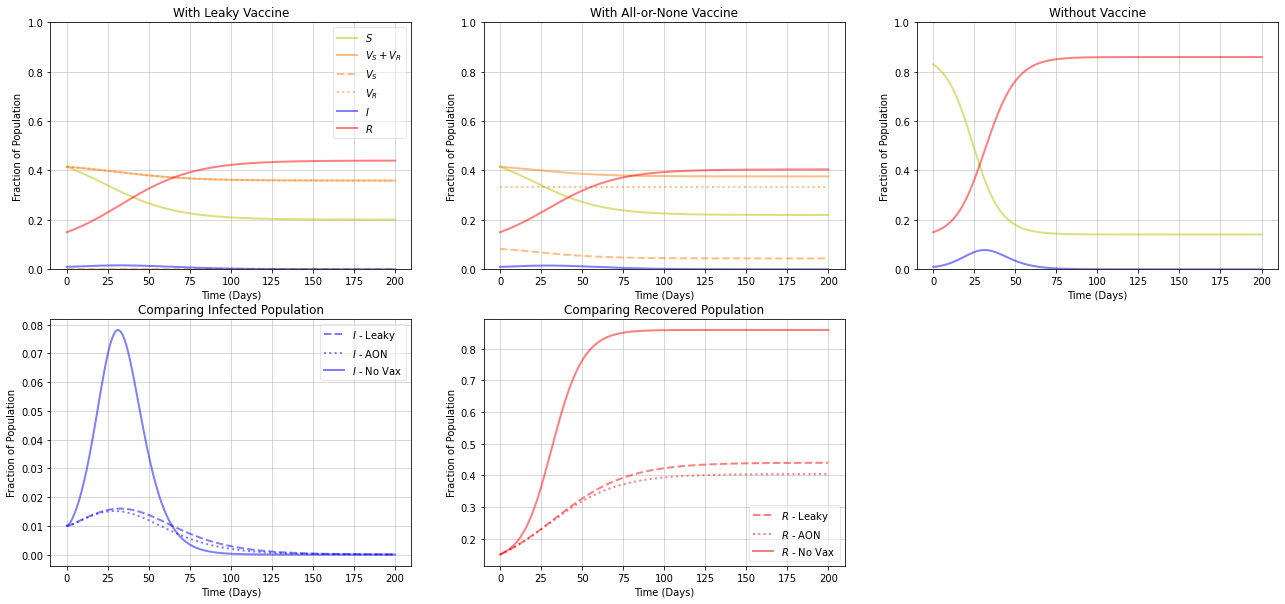

In [8]:
### define parameter values 
sigma = 1/4; gamma = 1/4; R0 = 2.5; beta = R0 * gamma; t = 200
#fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.01; i0 = 0.01; r0 = 0.15
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.8

# vaccine timing
tv = -1
#v = 0.02 # ln2 / 30.5 (half of S vaccinated by 30 days?)

# vaccination level
fv = s0 * 0.5

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

### run model - instantaneous vaccination
# leaky
sim_leaky_0_below = run_modified_seir_ivp(y0, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp(y0, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False)

## 2A

Motivation: Omicron wave in end of 2021/beginning of 2022 in countries with widespread mRNA vaccination campaigns

Prior immunity: 0

Vaccine timing: Pre-epidemic (0% epidemic size)

Vaccination level: 90% (of susceptible population)

Vaccine efficacy: 50%

R0: try to choose an R0 value such that on average about 10% of population is infected each month until epidemic ends (based on vaccinated)

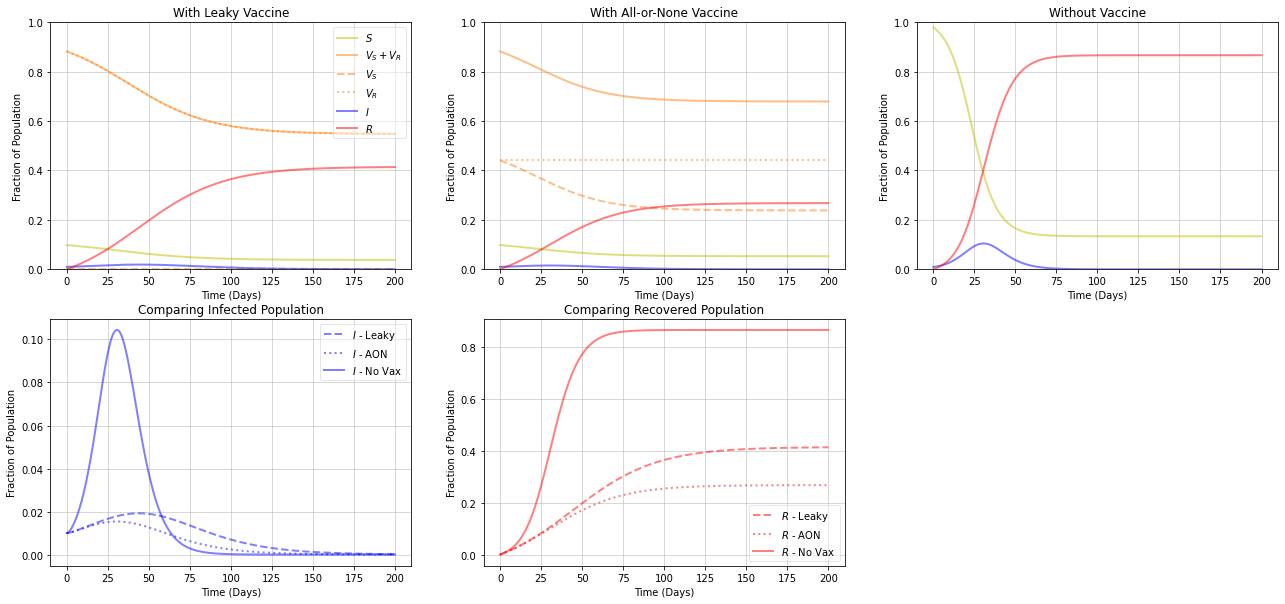

In [9]:
### define parameter values 
sigma = 1/4; gamma = 1/4; R0 = 2.3; beta = R0 * gamma; t = 200
#fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.01; i0 = 0.01; r0 = 0.0
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.5

# vaccine timing
tv = -1
#v = 0.02 # ln2 / 30.5 (half of S vaccinated by 30 days?)

# vaccination level
fv = s0 * 0.9 

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

### run model - instantaneous vaccination
# leaky
sim_leaky_0_below = run_modified_seir_ivp(y0, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp(y0, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False)

## 2B

Motivation: Omicron wave in end of 2021/beginning of 2022 in countries with widespread mRNA vaccination campaigns (taking into account uncertainty in vaccine efficacy for Omicron)

Prior immunity: 0

Vaccine timing: Pre-epidemic (0% epidemic size)

Vaccination level: 90% (of susceptible population)

Vaccine efficacy: 25%

R0: try to choose an R0 value such that on average about 10% of population is infected each month until epidemic ends (kept the same as 1A)

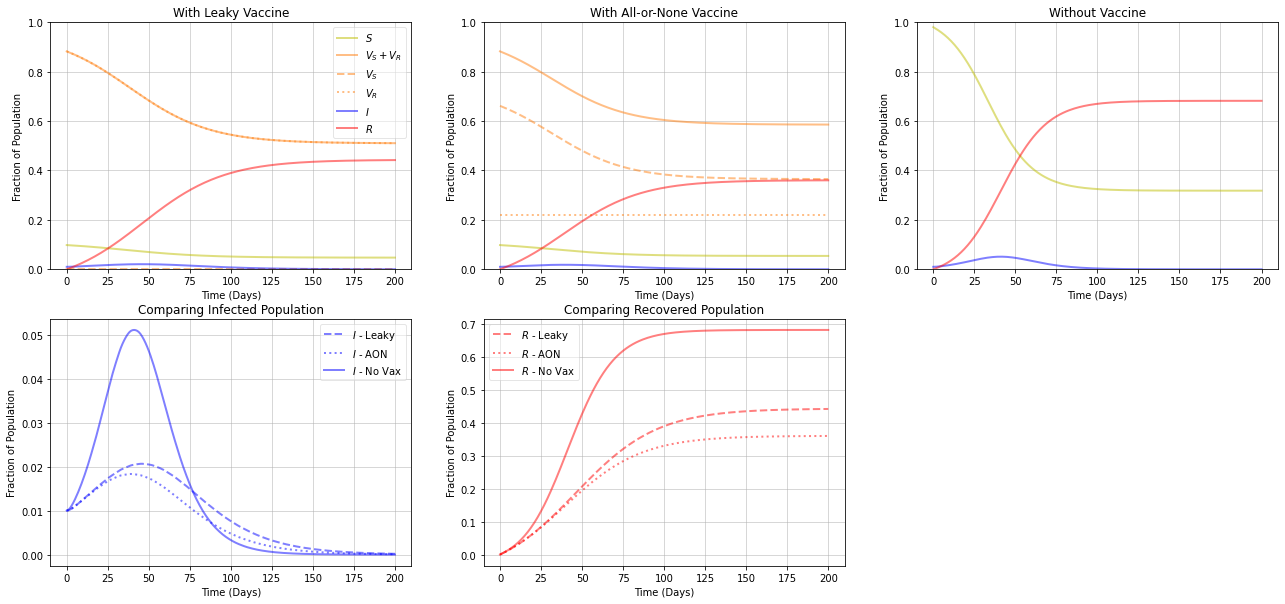

In [10]:
### define parameter values 
sigma = 1/4; gamma = 1/4; R0 = 1.65; beta = R0 * gamma; t = 200 # adjust R0
#fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.01; i0 = 0.01; r0 = 0.0
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.25

# vaccine timing
tv = -1
#v = 0.02 # ln2 / 30.5 (half of S vaccinated by 30 days?)

# vaccination level
fv = s0 * 0.9 

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

### run model - instantaneous vaccination
# leaky
sim_leaky_0_below = run_modified_seir_ivp(y0, t, tv, beta, sigma, gamma, fv, eps, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp(y0, t, tv, beta, sigma, gamma, fv, eps, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False)

## 3A

Motivation: Rapid control of an epidemic wave via vaccination. Similar to Israel WT wave early 2021, Portugal Delta wave summer 2021s

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, at max rate of about 20%/month

Vaccination level: 60% (of susceptible population)

Vaccine efficacy: 90%

R0: 1.7, Reff: 1.5

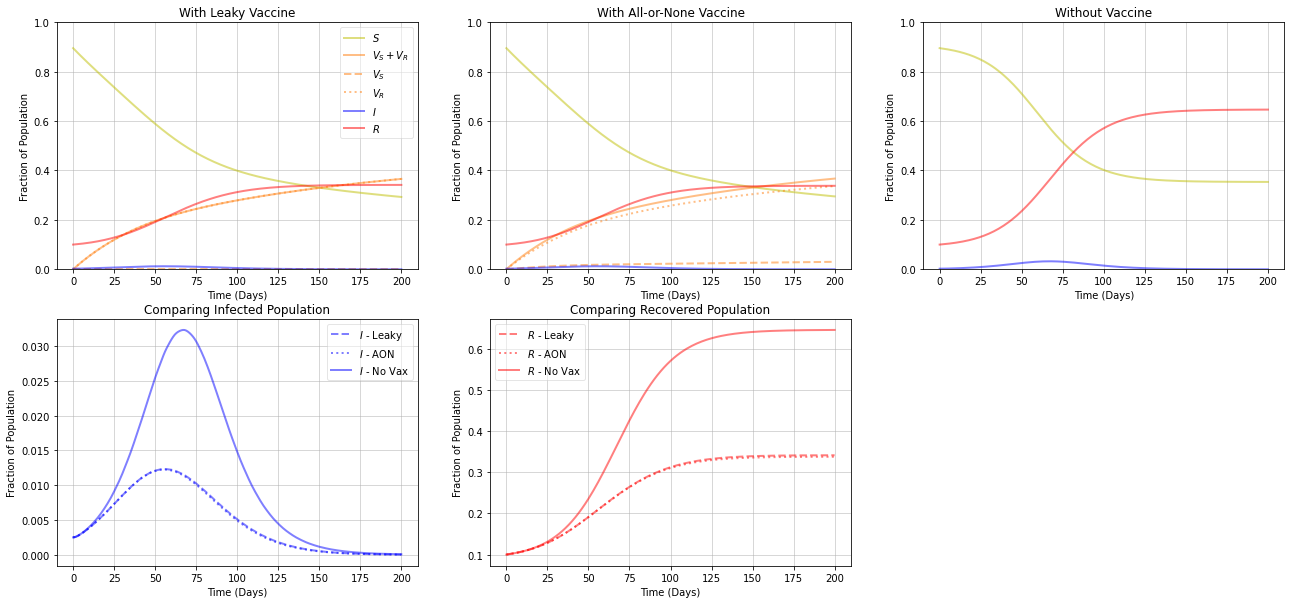

In [11]:
### define parameter values 
sigma = 1/4; gamma = 1/4; R0 = 1.7; beta = R0 * gamma; t = 200
#fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.0025; i0 = 0.0025; r0 = 0.1
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.9

# vaccine timing
tv = -1 # start vaccinating at the beginning
v = 0.2/30 # 1% (of susceptible) per day max rate
# calculated by v*s0 = 0.01, or should it just be v = 0.01?

# vaccination level
fv = s0 * 0.6

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

### run model - instantaneous vaccination
# leaky
sim_leaky_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False)

## 3B

Motivation: Slower control of an epidemic wave via vaccination. 

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, at max rate of about 10%/month

Vaccination level: 60% (of susceptible population)

Vaccine efficacy: 80%

R0: 1.7, Reff: 1.5

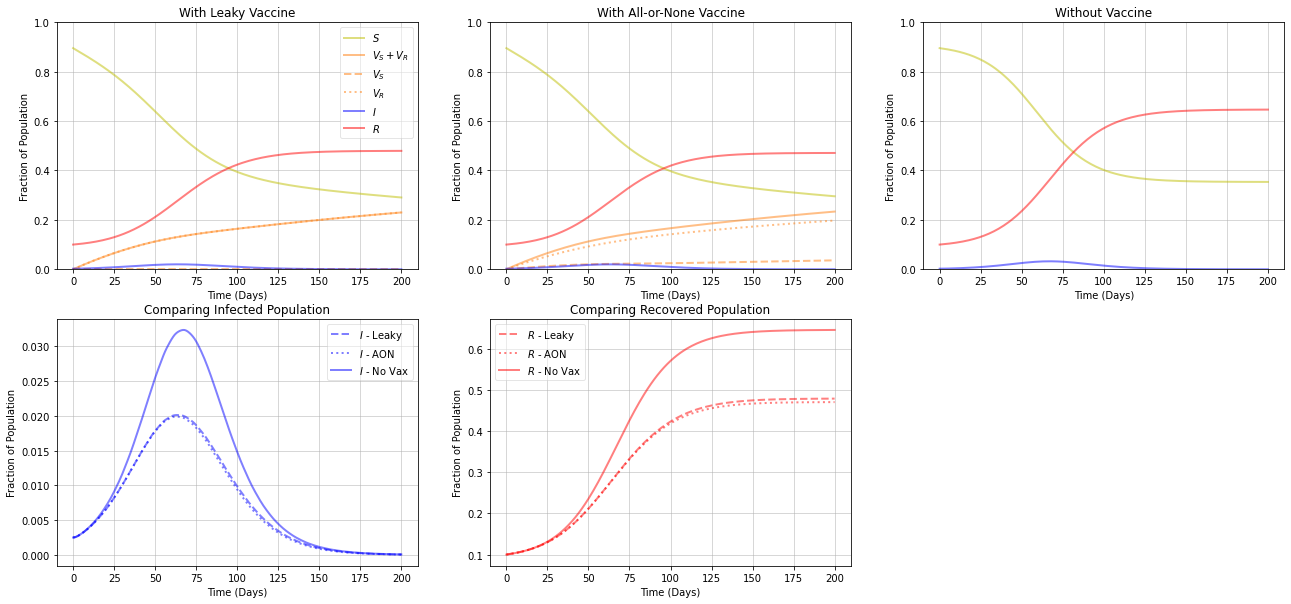

In [13]:
### define parameter values 
sigma = 1/4; gamma = 1/4; R0 = 1.7; beta = R0 * gamma; t = 200
#fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.0025; i0 = 0.0025; r0 = 0.1
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.8

# vaccine timing
tv = -1 # start vaccinating at the beginning
v = 0.1/30 # 1% (of susceptible) per day max rate
# calculated by v*s0 = 0.01, or should it just be v = 0.01?

# vaccination level
fv = s0 * 0.6

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

### run model - instantaneous vaccination
# leaky
sim_leaky_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False)

## 3C

**NOTE: Trying to find a situation where there is continuous vaccination but a big difference between the vaccine failure modes. I thought this would be one but can't seem to get much to happen!**

Motivation: Ongoing spread despite slow vaccintion to high levels with imperfect vaccine

Prior immunity: 10% (of total population)

Vaccine timing: Continous, during-epidemic, at max rate of about 10%/month

Vaccination level: 85% (of susceptible population)

Vaccine efficacy: 70%

R0: 1.5, Reff: 1.35

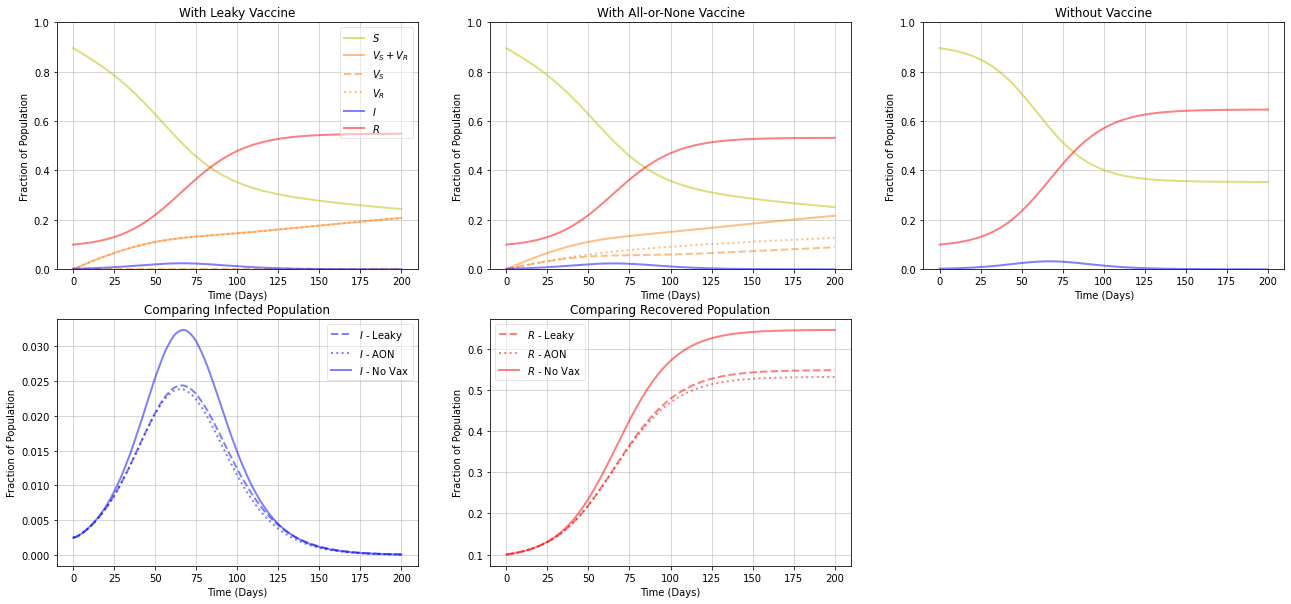

In [33]:
### define parameter values 
sigma = 1/4; gamma = 1/4; R0 = 1.7; beta = R0 * gamma; t = 200
#fc = 1/eps * (1 - 1/R0)

# initial conditions based on prior immunity
e0 = 0.0025; i0 = 0.0025; r0 = 0.10
s0=1-r0-e0-i0
y0 = [s0, e0, i0, r0]

# vaccine efficacy
eps = 0.5

# vaccine timing
tv = -1 # start vaccinating at the beginning
v = 0.1/30 # 1% (of susceptible) per day max rate
# calculated by v*s0 = 0.01, or should it just be v = 0.01?

# vaccination level
fv = s0 * 0.8

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

### run model - instantaneous vaccination
# leaky
sim_leaky_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False)

# IGNORE

## Vaccine Administered at 10% Epidemic Size

0.6345475295826897


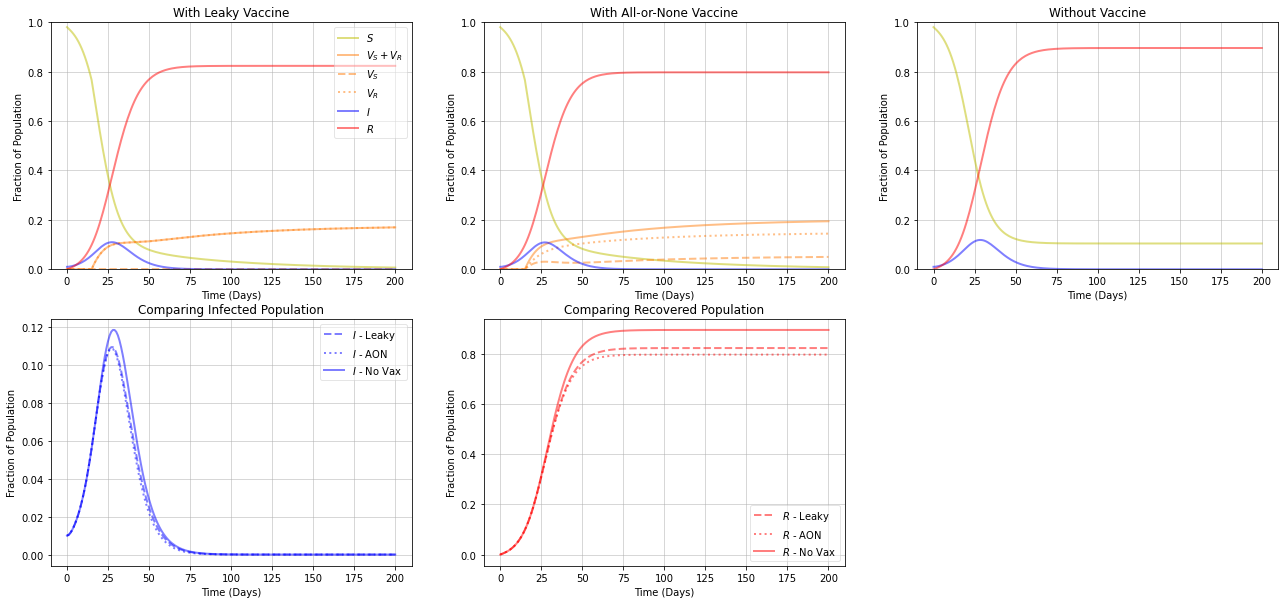

In [ ]:
# common parameter values
sigma = 1/4; gamma = 1/4; beta = 2.5 * gamma; eps = 0.6
t = 200; v = 0.02

# set initial conditions
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0
y0 = [s0, e0, i0, r0]

# no vaccination
sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

# set fc
def _reach_size10(t, y, beta, sigma, gamma): return y[3] - 0.1
_reach_size10.terminate=True

sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), events=_reach_size10, dense_output=True, t_eval = np.linspace(0, t, t+1))
s_temp = np.ravel(np.array(sol.y_events[0]))[0]
tv = int(np.round(np.ravel(np.array(sol.t_events))[0]))
fc = 1/eps * (1 - 1/(2.5*s_temp))
fv = fc * 0.8
print(fv)

### change in R is probably very subtle - I at time of vacacination is 0.0566

### run model
# leaky
sim_leaky_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'aon')

### plot time-series plot
plot_timeseries(sol.y, sim_leaky_0_below, sim_aon_0_below, savefig=False, filename='timeseries_pre_below')

## Vaccine Administered at 25% Epidemic Size

0.31660841450831767


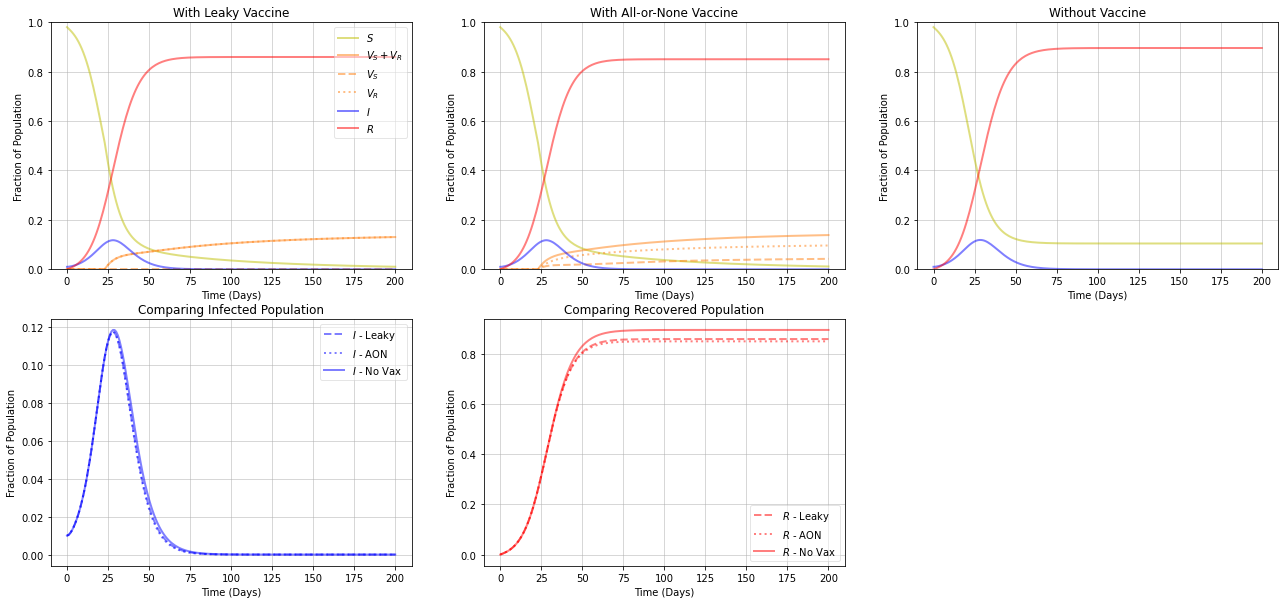

In [ ]:
# common parameter values
sigma = 1/4; gamma = 1/4; beta = 2.5 * gamma; eps = 0.6
t = 200; v = 0.02

# set initial conditions
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0
y0 = [s0, e0, i0, r0]

# no vaccination
sol_novax = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True, t_eval = np.linspace(0, t, t+1))

def _reach_size25(t, y, beta, sigma, gamma): return y[3] - 0.25
_reach_size25.terminate=True

sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), events=_reach_size25, dense_output=True)
s_temp = np.ravel(np.array(sol.y_events[0]))[0]
tv = int(np.round(np.ravel(np.array(sol.t_events))[0]))
fc = 1/eps * (1 - 1/(2.5*s_temp))
fv = fc * 0.8
print(fv)

### change in R is probably very subtle - I at time of vacacination is 0.0566

### run model
# leaky
sim_leaky_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'leaky')

# aon
sim_aon_0_below = run_modified_seir_ivp_cont(y0, t, tv, beta, sigma, gamma, fv, eps, v, mode = 'aon')

### plot time-series plot
plot_timeseries(sol_novax.y, sim_leaky_0_below, sim_aon_0_below, savefig=False, filename='timeseries_pre_below')